In [1]:
import tensorflow as tf
cuda_visible_devices = tf.config.list_physical_devices(device_type='GPU')
tf.config.set_visible_devices([], device_type='GPU')
# tf.config.get_visible_devices('GPU')

In [2]:
import os
import sys
sys.path.append('../')

import numpy as np
import scipy.io as sio
from tqdm.notebook import tqdm
import seaborn as sns
from skimage.transform import resize
import ipywidgets as widgets
import matplotlib.pyplot as plt
%matplotlib widget

import cdtipy
import cmr_interpolation
from cmr_rnd_diffusion import sampling

C:\Users\Jonat\anaconda3\envs\pyvista\lib\site-packages\cdtipy\reconstruction.py:11: UserWarning: No matlab installation found!
  warnings.warn("No matlab installation found!")
C:\Users\Jonat\anaconda3\envs\pyvista\lib\site-packages\cdtipy\registration.py:10: UserWarning: No matlab installation found!
  warnings.warn("No matlab installation found!")


# Generate eigen-value samples
---

The rejection sampling process first requires a "burn-in" phase, in which non-rejected sampling is used to generate an approximation of the eigenvalue distributions within the specified MD and FA ranges. A smoothed version of the FA - distribution is stored in a npz file which can be used to load the weights when instantiating the monte-carlo-sampler. It is used to construct the MC-decision threshold according to the rejection sampling condition:
```math
Let Y be a Random variable with density g(y)
Let f(Y) be the target distribution, \mathcal{U}(a, b)
Let U be a Random variable with density \mathcal{U}(0, cg(y))
if  U < f(Y) accept the sample.
```

The non-rejected sampling process is as follows:     
 1. Uniformly sample a MD value from specified range
 2. Sample 3 eigenvalues from the specified ranges
 3. Project the eigenvalue triple onto the plane defined by the sampled MD value, which results in a non-uniform distribution on the simplex (Fig1).
Fig.2 shows how a subspace of constant FA for a fixed, constant MD is a circle on the simplex plane. So the goal of the rejection sampling process is to have a uniform distribution inside the FA-ring defined by the box-constraints, for all MD planes.     

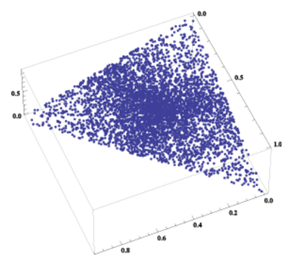
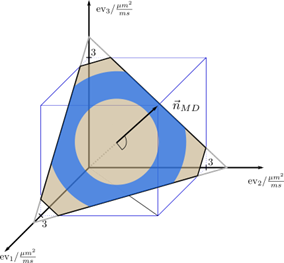
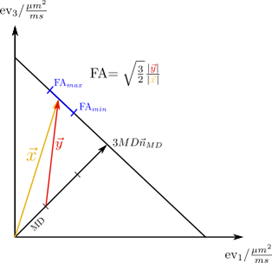    
---

## Define Parameter supports and burn in MC-Sampler

In [3]:
sampling_intervals = dict()

# Two example-configurations are given,
# feel free to add more by appending it to the dictionary 'sampling_intervals'
ev_support = np.array([[0, 3], ]* 3, dtype=np.float32)

trace_support = (np.array((-0.38, 0.38), dtype=np.float) + 1.45) * 3
fa_support = np.array([[-0.15, 0.15], ], dtype=np.float32) + 0.34 + 0.06
sampling_intervals.update({f'diffusion_healthy_exp': (ev_support, trace_support.copy(), fa_support.copy(), 1e5)})

trace_support = (np.array((-0.38, 0.38), dtype=np.float) + 1.56) * 3
fa_support = np.array([[-0.15, 0.15], ], dtype=np.float32) + 0.25 + 0.06
sampling_intervals.update({f'diffusion_lesion_exp': (ev_support, trace_support.copy(), fa_support.copy(), 1e5)})

directory = "." 
with tf.device("CPU:0"):
    for suffix, (eigenvalue_supports, tr_sup, fa_support, nburnin) in sampling_intervals.items():
        if not os.path.exists(f'{directory}/sampler_{suffix}.npz'):
            mc_sampler = sampling.MCRejectionSampler(tr_sup, eigenvalue_supports, fa_support, 
                                                     sampling_method=sampling.exponentially_sample_simplex, 
                                                     burn_in_samples=int(nburnin))
            mc_sampler.save(f'{directory}/sampler_{suffix}.npz')

Burn in FA distribution: 
 10 / 10Burn in FA distribution: 
 10 / 10

In [5]:
samplers = [sampling.MCRejectionSampler.from_savepath(f"{directory}/sampler_{s}.npz",
                                                             sampling_method=sampling.exponentially_sample_simplex) 
            for s in ("diffusion_healthy_exp", "diffusion_lesion_exp")]

with tf.device("CPU:0"):
    n = 20000
    healthy_samples = samplers[0].get_samples(n)
    lesion_samples = samplers[1].get_samples(n)

sample_populations = [healthy_samples.numpy(), lesion_samples.numpy()]    

Currently accepted samples: 20000  /  20000

To illustrate the resulting eigenvalue distrubtion the following cell plots the marginal distribution of the Eigen values, MD and FA as well as a joint 2D histogram of the tensor trace and FA 

In [6]:
from mpl_toolkits.mplot3d import Axes3D

plt.rc('axes', linewidth=2)
plt.rc('font', weight="bold", size=10)
plt.close('all')

tab = widgets.Tab(children=[widgets.Output() for _ in range(3)])
[tab.set_title(i,t) for i, t in enumerate(['Marginal Distributions', 'Joint FA-Tr Distribution', 'MC-descision boundaries'])]
display(tab)

with tab.children[0]:
    f, a = plt.subplots(1, 5, sharey=True)
    for s, c in zip(sample_populations, (None, "orange")):
        [sns.histplot(data=x, kde=True, ax=a[i], bins=30, alpha=0.4, color=c, stat='probability') 
         for  i, x in enumerate([*s.T, np.mean(s, axis=-1), np.array(cdtipy.tensor_metrics.fractional_anisotropy(s))])]
    
    [(a[i].set_title(t), a[i].grid(True), a[i].legend(['healthy', 'lesion'])) for i, t in enumerate(['EV1', 'EV2', 'EV3', 'MD', 'FA'])], 
    
    for ax in a:
        ax.xaxis.get_ticklocs(minor=True)
        ax.minorticks_on()
    
    [_.set_xlabel(r"$10^{-3}mm^2/s$") for _ in a[:-1]]
    f.set_size_inches(12, 5), f.tight_layout()
    plt.show(f)
    
with tab.children[1]:
    def get_surface_arrays(evs):
        fa, trace = np.array(cdtipy.tensor_metrics.fractional_anisotropy(evs)), np.sum(evs, axis=1)
        print(fa.shape)
        fa_bin_edges, md_bin_edges = np.linspace(0., 0.65, 25), np.linspace(0.5, 6.5, 25)
        H, x_edges, y_edges = np.histogram2d(fa, trace, bins=(fa_bin_edges, md_bin_edges))
        X, Y = np.meshgrid( (fa_bin_edges[1:] + fa_bin_edges[0:-1]) / 2, 
                            (md_bin_edges[1:] + md_bin_edges[0:-1]) / 2, indexing='ij')
        return X, Y, H
    f = plt.figure()
    ax = f.add_subplot(111, projection='3d')
    ax.plot_surface(*get_surface_arrays(healthy_samples)), ax.set_xlabel('FA'), ax.set_ylabel('Tr'), f.suptitle('Joint distribution')
    
with tab.children[2]:
    f, ax = plt.subplots(1, 1)
    [ax.plot(np.linspace(*sampler._value_range, sampler._n_bins), sampler.mc_decision_boundaries.flatten(), ".--") for sampler in samplers]
    plt.show(f)